<a href="https://colab.research.google.com/github/RCutrino/MLPNS_RCutrino/blob/main/MLPN23_linear_regretion23_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Fitting a line to GRB afterglow photometry**

This exercise teaches you to fit the simplest model to data: a line, using different methods.

Notes:

a line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process

we will learn later that a broken powerlaw is a prefer model for the GRB afterglow. But this exercise is about fitting lines: Linear Regression

**TL;DR: we measure a quantity named magnitude over time, which is an inverse logaritmic measure of brightness of the GRB, and which is expected to change it roughly linearly with the logarithm of time.**

About GRB Afterglows

Gamma-ray bursts (GRBs) are bright X-ray and gamma-ray flashes observed in the sky, emitted by distant extragalactic sources. They are associated with the creation or merging of neutron stars or black holes; processes which result in an explosive outburst of material moving incredibly close to the speed of light ref. Long after the initial burst of gamma rays has subsided, gamma ray bursts (GRBs) are still observable at less energetic wavelengths. Although no formal definition exists, this smoothly varying, lower energy radiation that may be visible for several days following the GRB itself, is usually referred to as the GRB afterglow.

**Details:** The light that we measure from these explosions changes over time, so we can study its time series. The change in light is exponential, not linear, but if we take the logarithm of the light, that chance may be linear, since the logarithm is the inverse of exponent. The logarithm of the light flux is called magnitude in astronomy. A line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process.

It is believed that the afterglow originates in the external shock produced as the blast wave from the explosion collides with and sweeps up material in the surrounding interstellar medium. The emission is synchrotron emission produced when electrons are accelerated in the presence of a magnetic field. The successive afterglows at progressively lower wavelengths (X-ray, optical, radio) result naturally as the expanding shock wave sweeps up more and more material causing it to slow down and lose energy.

X-ray afterglows have been observed for all GRBs, but only about 50% of GRBs also exhibit afterglows at optical and radio wavelengths ref

In reality, the correct model is a broken powerlaw: the slope of the line "breaks" or changes, at some point in time. But this exercise is about fitting lines. But in the end we will use MCMC and find out which model is better


# **initial import**

In [20]:
import numpy as np
import pandas as pd
import pylab as pl
%pylab inline
import matplotlib.cm as cm

# I have created a stylesheet to define default plot behaviors. 
# This stylesheet changes the default parameters stored in the dictionary matplitlib.rcParams
pl.style.use("https://raw.githubusercontent.com/fedhere/MLTSA22_FBianco/master/fbb.mplstyle")
pl.rcParams['font.size'] = 20

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.9/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


#**Task 1**: Read and prepare the input dataset
I am reading the data with Pandas. Pandas has excellent utilities for input-output of tabular data and also for time variables. We will use it throughout as our main package to acquire and manipulate data

In [21]:
grbAG = pd.read_csv("https://raw.githubusercontent.com/fedhere/MLPNS_FBianco/main/linearRegression/grb050525A.csv")
grbAG.head()

,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


##Create the log-time variable
We will fit a line in log space. The magnitude column I gave you is the logarithm (base 10) of the flus so that is already available. Create a logarithm base 10 of the time variable

(Fitting a line in log-log space corresponds to fitting a powerlaw y=x^a in natural space. Note: we mean logbase 10, use numpy.log10())

In [22]:
grbAG.time

0           66
1           67
2           68
3           69
4           70
        ...   
114      63738
115      74798
116     128928
117     971360
118    1171176
Name: time, Length: 119, dtype: int64

In [23]:
grbAG["logtime"] = np.log10(grbAG.time)
grbAG.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


##Visualize the data
The data are photometric measurements: measurement of flux from an exploding star. The flux is measured in different photometric bands, i.e. within different wavelength range. You can think about this as a filter that would limit the light collected by a camera to a single color, e.g. red, blue, or green. In most all cameras (your phone camera for example) collect data in RGB bands saparately and combine them to create a "color picture". Our eyes also perceive color in 3 bands, R, G, B.

The information about the photometric band is stored in the variable grbAG.filter. If I wanted to retrieve all magnitudes for filter 'V' I would do grbAG.loc[grbAG["filter"] == f, "mag"].

Plot the data with different colors for different photometric bands.

Use pl.errorbar to display the uncertainties in the data - if you do not know how to use pl.errorbar you can symply type

pl.errorbar? in a cell to retrieve the help

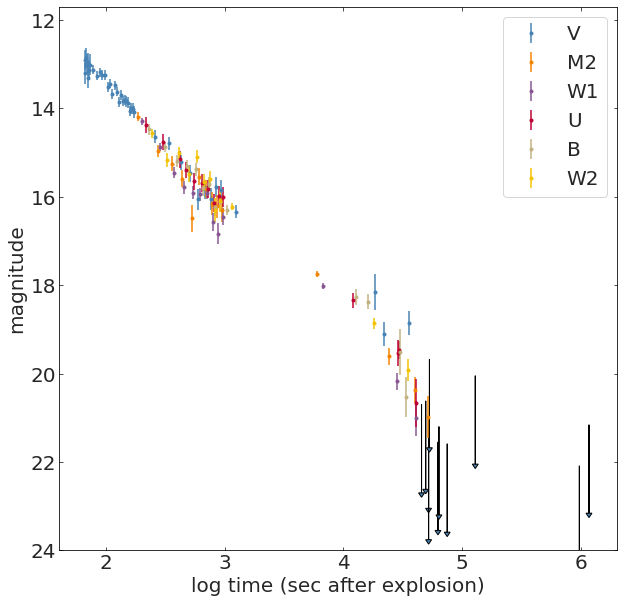

In [27]:
#create a figure container and an axis object inside of it

ax = pl.figure(figsize=(10,10)).add_subplot(111)
    
#loop on every filter to plot - this will give differnt colors naturally. 
#Use pl.errorbar to plot the uncertainties

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f].logtime,
             grbAG[grbAG["filter"] == f].mag, fmt=".",
             yerr=grbAG[grbAG["filter"] == f].magerr, label=f)
    
    
# replot to add a better marker (optional)
#for f in grbAG["filter"].unique():
#    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"], 
#               grbAG.loc[grbAG["filter"] == f, "mag"], 
#               alpha=1, s=100, linewidth=2,
#               label=f,
#               edgecolor='#cccccc')
    

# plot the upperlimits as arrows
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime, 
             grbAG.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k')

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
pl.ylim(24,11.7)          
pl.legend()

#Always rememebr you axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time (sec after explosion)", fontsize=20);

Figure 1: Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows.

##Clean the data: Remove upper limits
This data includes upper limits which I plotted as downward errors. upper and lower limits (technically called "censored data" are extremely hard to deal with in modeling). For now, lets just remove them.

To remove the upper limits you can "broadcast" the data: in pandas that looks like

grbAG.loc[grbAG.upperlimit == 0]

If you do not know how to remove selected rows from a dataframe based on a condition look at this gist https://gist.github.com/fedhere/e9cd67d9dc0357ee547e03a12ceb4719

The information about whether the point is an upper limit or a measurement is stored in the variable grbAG.upperlimit.

In [19]:
grbAG.loc[grbAG.upperlimit == 0]
grbAG

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098
...,...,...,...,...,...,...
114,W1,63738,NaN,21.20,1,4.804398
115,M2,74798,NaN,21.59,1,4.873890
116,U,128928,NaN,20.05,1,5.110347
117,V,971360,NaN,22.09,1,5.987380


#**Task 2: Fit models to data**


##Task 2a: Solve using the Normal Equation
You can use the code I put in the slides for this - you can copy and paste it but you will learn most if you try type it down and make sure you understand it line by line!!

It can be shown that the best linear fit to data is given by the equation:

$(X^T \cdot X)^{-1} \cdot X^T \cdot \vec{y}$

The solution is a tuple of 2 parameters: sloper and intercept. Therefore the input has to be Nx2

In [28]:
x = grbAG[grbAG.upperlimit == 0].logtime.values

X = np.c_[np.ones((len(grbAG) - grbAG.upperlimit.sum(), 1)),
          x]


y = grbAG.loc[grbAG.upperlimit == 0].mag.values
print("shape of the input array X", X.shape)
print("shape of the input array y", y.shape)
#note the shape in python is flipped compared to the shape in linear algebra

shape of the input array X (108, 2)
shape of the input array y (108,)


In [30]:
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print ("best fit parameters from the Normal Equation: " + 
       "intercept {:.2f}, slope {:.2f}".format(*theta_best))

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


##Task 2b: Fit a line to the data with sklearn LinearRegression
The exogenous (independent) variable is grbAG.logtime.

In [31]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

lr.fit(X, y)
print ("best fit parameters from the sklearn LinearRegression(): " + 
       "intercept {:.2f}, slope {:.2f}".format(lr.intercept_, lr.coef_[1]))

best fit parameters from the sklearn LinearRegression(): intercept 8.58, slope 2.51


##Fit a line to the data (excluding the upper limits) by minimizing an objective function

In [32]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
from scipy.optimize import minimize

def line(x, intercept, slope):
    return slope * x + intercept
def l1(args, x, y):
    a, b = args
    return sum(np.abs(y - line(a, b, x)))


initialGuess = (10, 1)

l1Solution = minimize(l1, initialGuess, args=(x, y))
print(l1Solution)
print("")
print("best fit parameters from the minimization of L1: " + 
       "slope {:.2f}, intercept {:.2f}".format(*l1Solution.x))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 26.30434056218986
        x: [ 2.640e+00  8.227e+00]
      nit: 11
      jac: [-1.958e+00  0.000e+00]
 hess_inv: [[ 7.594e-03 -1.591e-02]
            [-1.591e-02  3.413e-02]]
     nfev: 172
     njev: 55

best fit parameters from the minimization of L1: slope 2.64, intercept 8.23


##Fit a line to the data (excluding the upper limits) by minimizing an objective function that accounts for the measurements uncertainties

Since the data has uncertainty, choose the $χ^2$
 (chi squared) function as your objective function. 

In [33]:
def chi2(args, x, y, s):
    a, b = args
    return sum((y - line(a, b, x))**2 / s)

x = grbAG[grbAG.upperlimit == 0].logtime.values
y = grbAG.loc[grbAG.upperlimit == 0].mag.values
s = grbAG.loc[grbAG.upperlimit == 0].magerr.values

initialGuess = (10, 1)

chi2Solution = minimize(chi2, initialGuess, args=(x, y, s))
print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " + 
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 58.49837428948362
        x: [ 2.500e+00  8.582e+00]
      nit: 5
      jac: [ 4.768e-06 -1.431e-06]
 hess_inv: [[ 1.398e-03 -3.813e-03]
            [-3.813e-03  1.113e-02]]
     nfev: 24
     njev: 8

best fit parameters from the minimization of the chi squared: slope 2.50, intercept 8.58


#**Solution**

##**Plot all the solutions**

Create a function that uses the parameters you input and plots a line. Add a legend that describes which line corresponds to what.

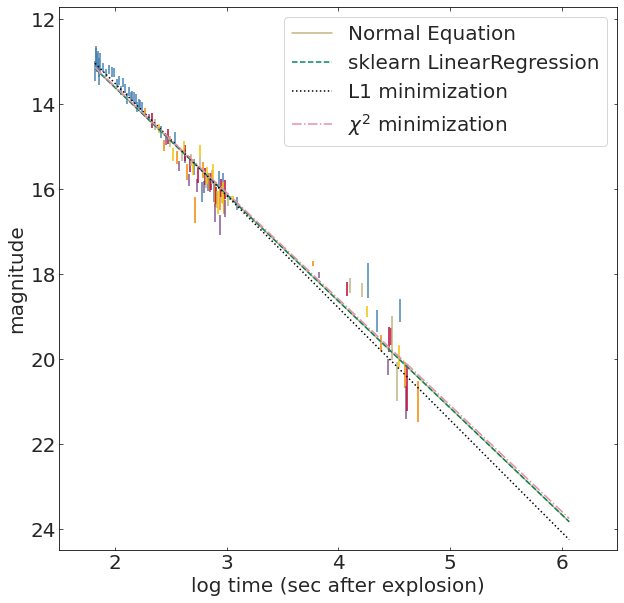

In [35]:
def plotline(pars, x, color='k', symbol='-', label='model', ax=ax):
    slope, intercept = pars
    y = line(x, intercept, slope)
    ax.plot(x, y, ls=symbol, c=color, label=label)


ax = pl.figure(figsize=(10,10)).add_subplot(111)

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"], 
                grbAG.loc[grbAG["filter"] == f, "mag"], 
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"], fmt='.', ms=0,
                fcolor=None, label=None)
    
#normal equation
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime.values, 
         color='#'+colors[0], 
         label="Normal Equation", ax=ax)
#sklearn
plotline((theta_best[::-1]), grbAG.logtime,  
         color='#'+colors[2], symbol='--',
         label="sklearn LinearRegression", ax=ax)
#minimize L1
plotline((l1Solution.x), grbAG.logtime,  
         symbol=':',
         label="L1 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x), grbAG.logtime, 
         color='#'+colors[3], symbol='-.',
         label=r"$\chi^2$ minimization", ax=ax)

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time (sec after explosion)", fontsize=20);

Figure 2: Same as Figure 1, but with linear regression models plotted. The models correspond to the best fit line to the data (excluding upper limits) calculated analytically by solving the normal equation, by solving the fit analysitcally with sklearn.LinearRegression(), and by minimizing the objective functions L1 and Chi squared. The models are indicated in the legend

##Create a table with the results of each method

In [43]:
from tabulate import tabulate

data = [["Normal equation",2.51,8.58],
        ["sklearn.LinearRegression()",2.51,8.58],
        ["minimize L1",2.64,8.23],
        ["minimize chi2",2.50,8.58]]

col_names=["Method","Slope","Intercept"]
print(tabulate(data, headers=col_names))

Method                        Slope    Intercept
--------------------------  -------  -----------
Normal equation                2.51         8.58
sklearn.LinearRegression()     2.51         8.58
minimize L1                    2.64         8.23
minimize chi2                  2.5          8.58
